<a href="https://colab.research.google.com/github/v-keerthana/DeepLearning/blob/main/Classification_and_Segmentation_Of_Tuberculosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
def contour_img(image,mask):
    mask = mask.astype(np.uint8)
    edge = cv2.Canny(mask,100,200)
    contours, hierarchy = cv2.findContours(edge,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 
    cv2.drawContours(image, contours, -1,(0,255,0), 2)
    return image

In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam,RMSprop
import cv2
def segment(image_path,flag):
  def dice_coef(y_true, y_pred):
      y_true_f = keras.flatten(y_true)
      y_pred_f = keras.flatten(y_pred)
      intersection = keras.sum(y_true_f * y_pred_f)
      return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

  def dice_coef_loss(y_true, y_pred):
      return -dice_coef(y_true, y_pred)

  def unet(input_size=(256,256,1)):
      inputs = Input(input_size)
      
      conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
      conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
      pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

      conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
      conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
      pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

      conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
      conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
      pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

      conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
      conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
      pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

      conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
      conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

      up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
      conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
      conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

      up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
      conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
      conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

      up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
      conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
      conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

      up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
      conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
      conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

      conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

      return Model(inputs=[inputs], outputs=[conv10])


  
  model = unet(input_size=(224,224,1))
  model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                    metrics=[dice_coef, 'binary_accuracy'])
  # model.summary()

  import numpy as np 
  import tensorflow as tf
  import pandas as pd
  from tqdm import tqdm
  import os
  from cv2 import imread, createCLAHE 
  import cv2
  from glob import glob
  %matplotlib inline
  import matplotlib.pyplot as plt
  import cv2
  from keras.preprocessing import image

  model.load_weights("/content/gdrive/MyDrive/cxr_reg_weights.best_224.hdf5")
  img = image.load_img(image_path, target_size = (224, 224))
  im = image.load_img(image_path, target_size = (224, 224),color_mode="grayscale")
  if flag:
    groundtruthpath=image_path[:-4]+"_mask.png" 
    im2=image.load_img(groundtruthpath,target_size=(224,224),color_mode="grayscale")
  im = np.expand_dims(im, axis = 0)
  img=np.expand_dims(img,axis=0)
  #im2=np.expand_dims(im2,axis=0)
  # plt.figure(figsize=(20,10))
  # f1=plt.subplot(1,3,1)
  # f1.set_title("ORIGINAL_IMAGE")
  #f.add_subplot(131)
  #plt.imshow(np.squeeze(im))
  pred=model.predict(im)
  # new_mask=np.copy(im)
  im_copy=np.copy(im)
  im_copy2=np.copy(im)
  if flag:
    ground=np.copy(im2)
    ground = cv2.convertScaleAbs(ground)
  im_copy=cv2.convertScaleAbs(im_copy)
  #im_copy=cv2.cvtColor(im_copy,cv2.COLOR_BGR2GRAY)
  pred_copy = np.copy(pred[0])
  pred_copy1 = np.copy(pred[0])
  pred_copy = cv2.convertScaleAbs(pred_copy)
  #pred_copy1=cv2.convertScaleAbs(pred_copy1)
  #print(pred_copy.shape,ground.shape)
  # for i in range(new_mask[0].shape[0]):
  #   for j in range(new_mask[0].shape[1]):
  #     if pred[0][i][j]==0:
  #       new_mask[0][i][j]=0
  #ret, thresh = cv2.threshold(im_copy, 150, 255, cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(pred_copy, 
    cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  if flag:
    contours1, hierarchy1 = cv2.findContours(ground, 
      cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  # cv2.drawContours(pred_copy1,contours,-1,(0,255,0),3)
  show=np.copy(img)
  show1=np.copy(img)
  show2=np.copy(img)
  # cv2.drawContours(pred_copy1, contours, -1, (255,0,0), 3)
  # plt.imshow(pred_copy1)
  #seg=contour_img(im,im2)
  img=np.asarray(img)
  im=np.asarray(im)
  #print(img.shape,im.shape)
  for i in contours:
    for j in i:
      for k in j:
        show1[0][k[1]][k[0]]=(255,0,0)
  if flag:    
    for i in contours1:
      for j in i:
        for k in j:
          show2[0][k[1]][k[0]]=(255,0,0)

  # for i in range(pred_copy.shape[0]):
  #   for j in range(pred_copy.shape[1]):
  #     # if pred_copy[i][j]!=1:
  #     #   im_copy[0][i][j]=255
  #     if pred_copy[i][j]==0:
  #       pred_copy[i][j]=1
  #     else:
  #       pred_copy[i][j]=0
  # f2=plt.subplot(1,3,2)
  # f2.set_title("GROUND_TRUTH")
  # plt.imshow(np.squeeze(im_copy2))
  # f3=plt.subplot(1,3,3)
  # f3.set_title("PREDICTION")
  # plt.imshow(np.squeeze(im_copy))
  show=np.squeeze(show)
  show2=np.squeeze(show2)
  show1=np.squeeze(show1)
  if flag:
    return (show,show2,show1)
  return (show,show1)

In [ ]:
import tensorflow as tf 

In [ ]:
from tensorflow import keras

In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
from tensorflow.keras.models import load_model
new_model=load_model('/content/gdrive/MyDrive/model_tb.h5')

In [ ]:
# new_model = tf.keras.models.load_model('model_tb.h5')
new_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
from keras.preprocessing import image
import numpy as np


TUBERCULOSIS :  [[0.89949125]]


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


(1, 224, 224, 3) (1, 224, 224)


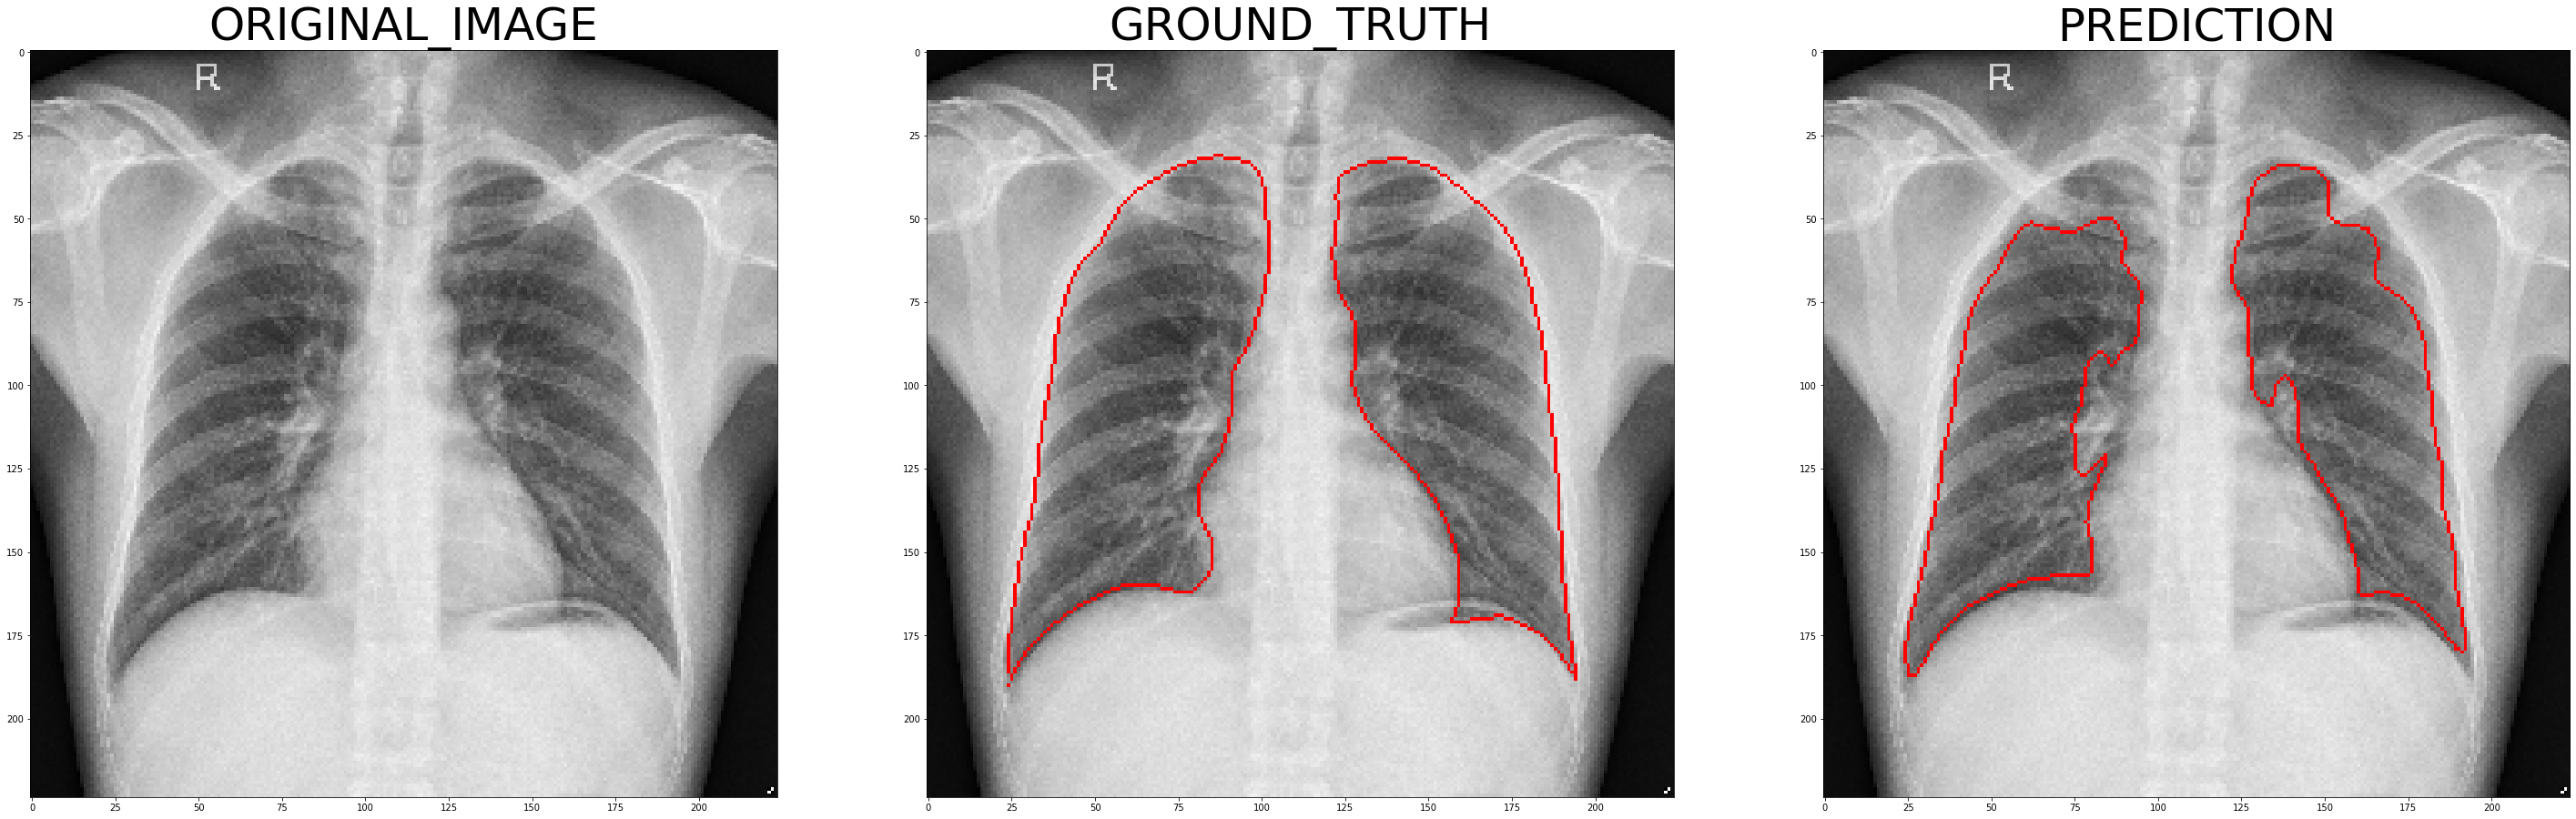

In [ ]:
image_path='/content/gdrive/MyDrive/CHNCXR_0335_1.png'
test_image = image.load_img(image_path, target_size = (224, 224)) 
test_image = np.expand_dims(test_image, axis = 0)
value_predicted = new_model.predict(test_image)
if((value_predicted)>0.5):
  print("TUBERCULOSIS : ",value_predicted)
  im,show1,show2=segment(image_path)
else:
  print("NORMAL : ",value_predicted)

plt.figure(figsize=(50,50))
f1=plt.subplot(1,3,1)
plt.imshow(im)
# f1.set_title("TUBERCULOSIS:",value_predicted)
f1.set_title("ORIGINAL_IMAGE",fontsize=50)
#k+=1
f2=plt.subplot(1,3,2)
f2.set_title("GROUND_TRUTH",fontsize=50)
plt.imshow(show1)
#k+=1
f3=plt.subplot(1,3,3)
f3.set_title("PREDICTION",fontsize=50)
plt.imshow(show2)


TUBERCULOSIS :  [[0.9689423]]


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


TUBERCULOSIS :  [[0.98882514]]
TUBERCULOSIS :  [[0.89949125]]
TUBERCULOSIS :  [[0.98980135]]
TUBERCULOSIS :  [[0.9155157]]


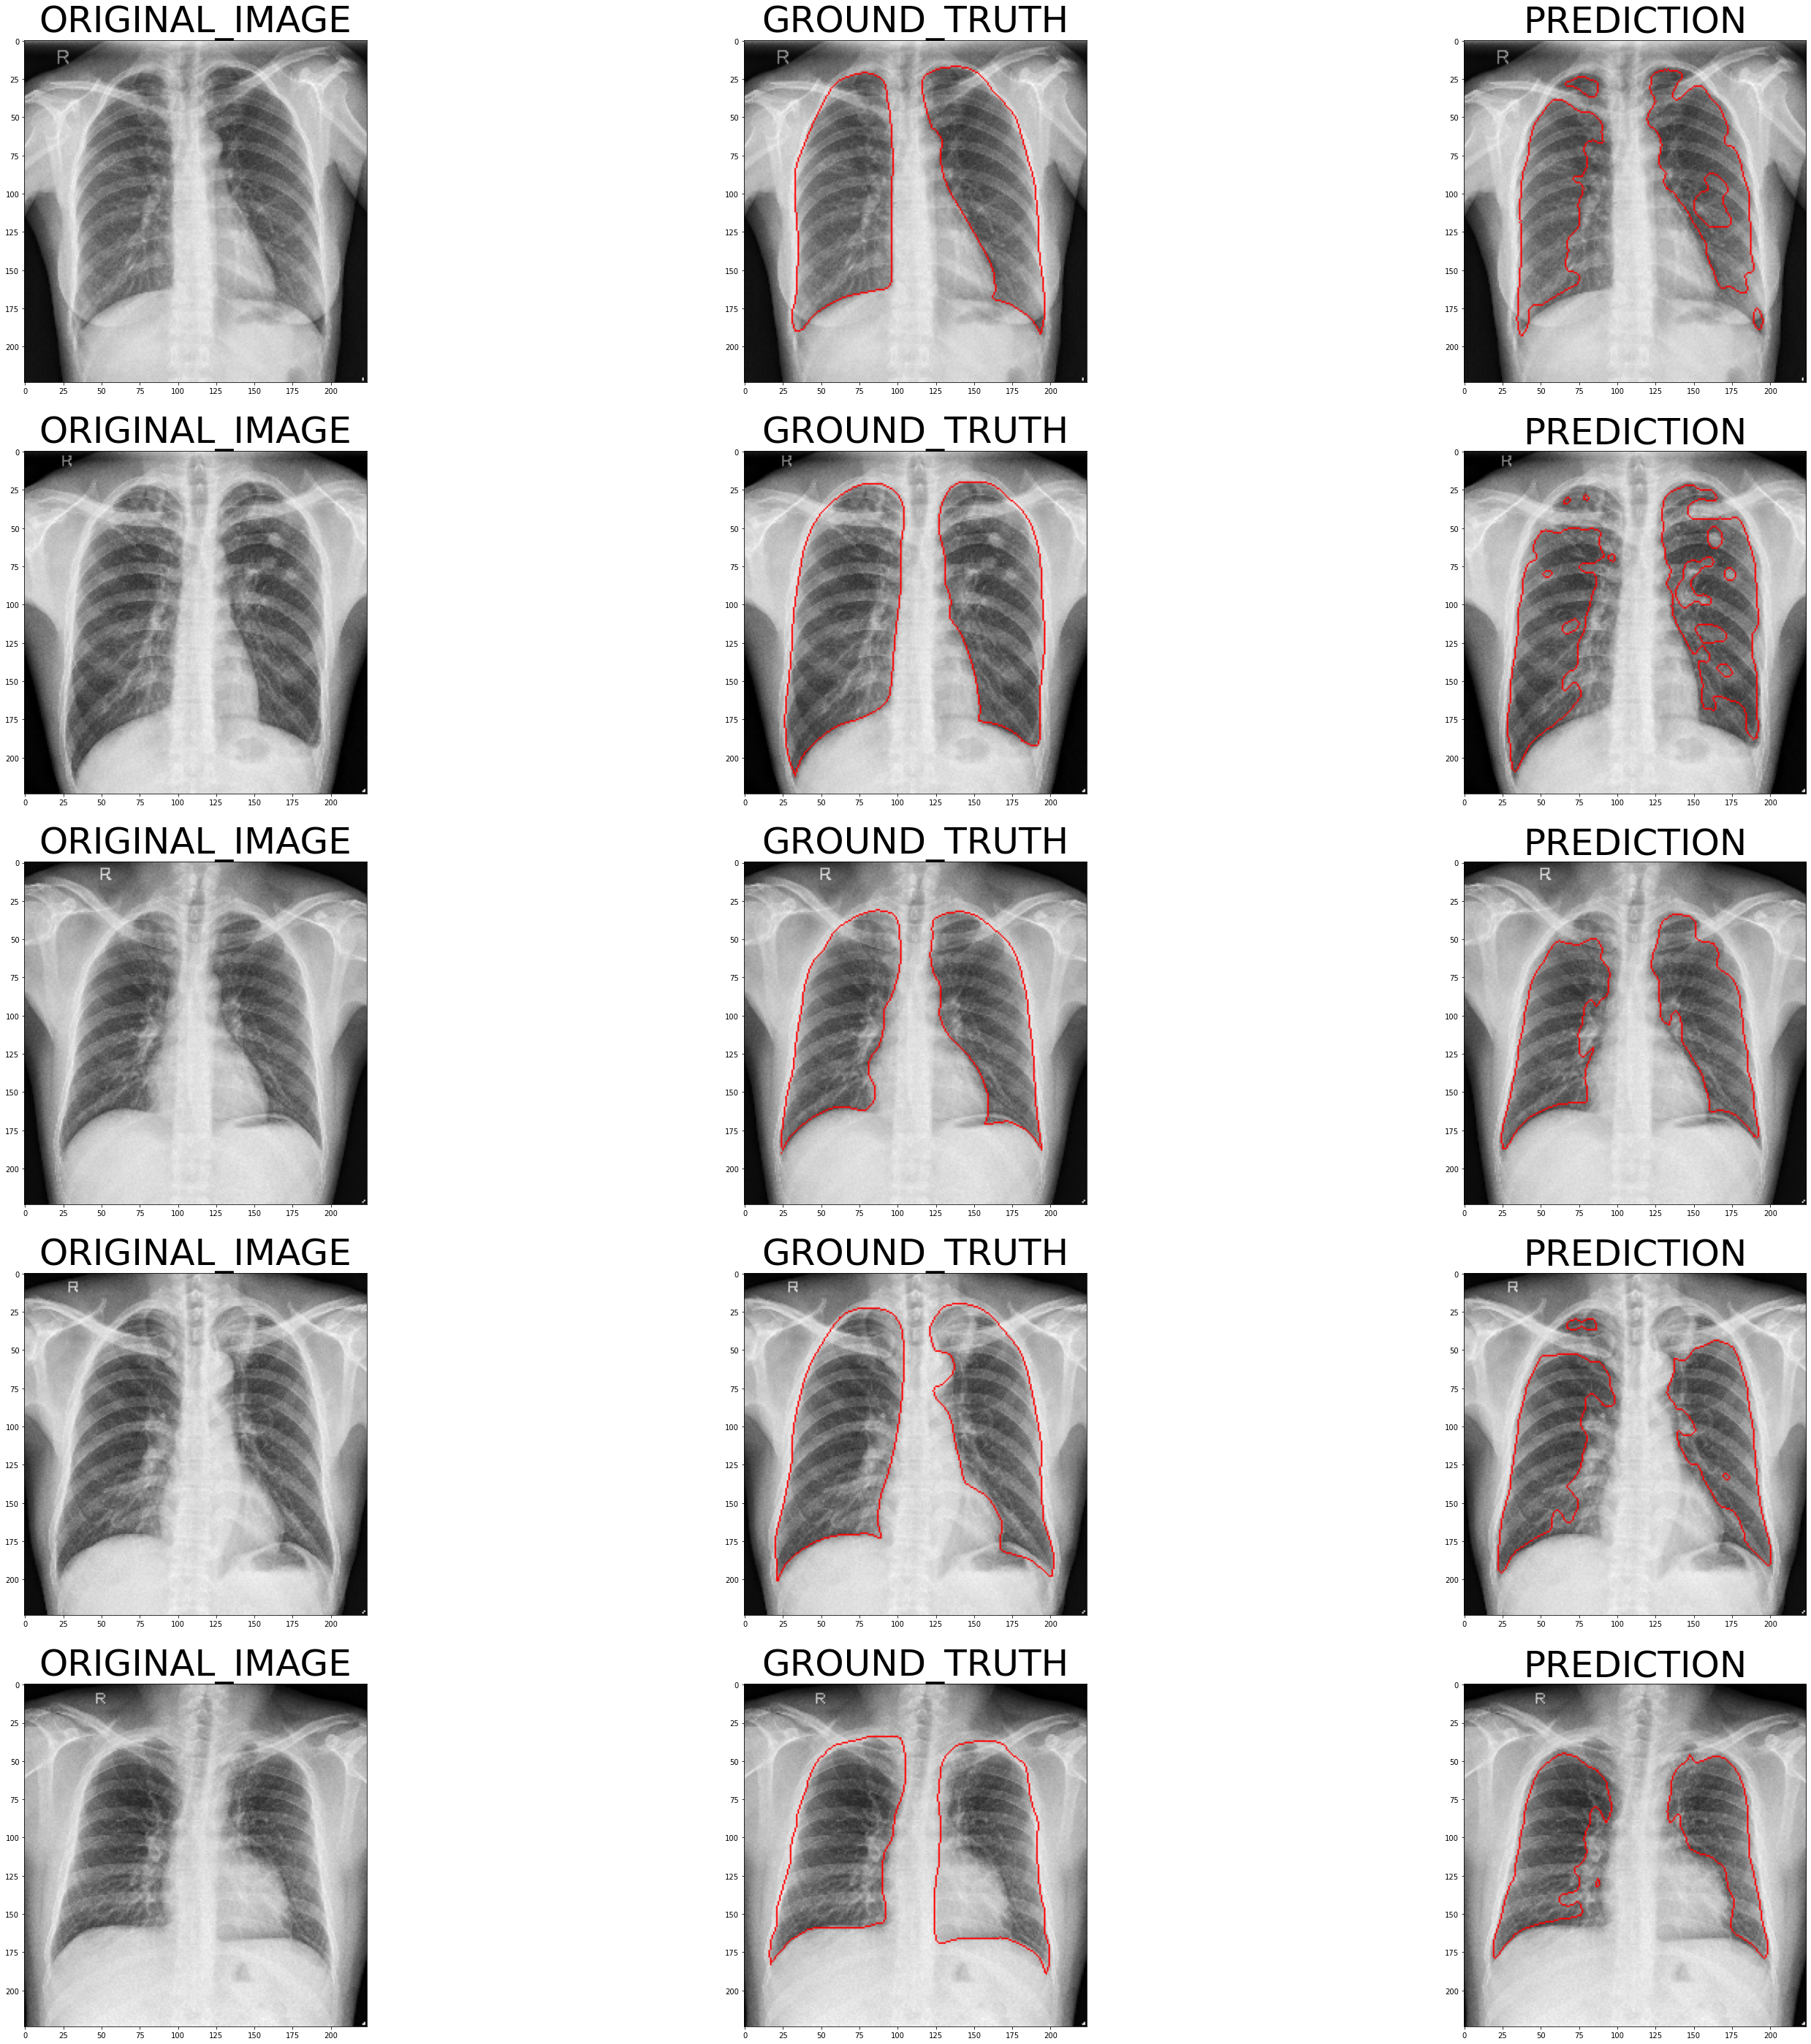

In [ ]:
#image_path='/content/CHNCXR_0329_1.png'
import matplotlib.pyplot as plt
images=[]
paths=['/content/gdrive/MyDrive/CHNCXR_0329_1.png','/content/gdrive/MyDrive/CHNCXR_0330_1.png','/content/gdrive/MyDrive/CHNCXR_0335_1.png','/content/gdrive/MyDrive/CHNCXR_0332_1.png','/content/gdrive/MyDrive/CHNCXR_0340_1.png']
for i in range(len(paths)):
  image_path=paths[i]
  test_image = image.load_img(image_path, target_size = (224, 224)) 
  test_image = np.expand_dims(test_image, axis = 0)
  value_predicted = new_model.predict(test_image)
  if((value_predicted)>0.5):
    print("TUBERCULOSIS : ",value_predicted)
    images.append(segment(image_path,True))
  else:
    print("NORMAL : ",value_predicted)
plt.figure(figsize=(50,50))
k=1
for i in range(1,6):
  f1=plt.subplot(5,3,k)
  plt.imshow(images[i-1][0])
  f1.set_title("ORIGINAL_IMAGE",fontsize=50)
  k+=1
  f2=plt.subplot(5,3,k)
  f2.set_title("GROUND_TRUTH",fontsize=50)
  plt.imshow(images[i-1][1])
  k+=1
  f3=plt.subplot(5,3,k)
  f3.set_title("PREDICTION",fontsize=50)
  plt.imshow(images[i-1][2])
  k+=1

In [ ]:
def plot(x,y,z,value_predicted):
  plt.figure(figsize=(50,50))
  f1=plt.subplot(1,3,1)
  plt.imshow(x)
  # f1.set_title("TUBERCULOSIS:",value_predicted)
  f1.set_title("ORIGINAL_IMAGE",fontsize=50)
  #k+=1
  f2=plt.subplot(1,3,2)
  f2.set_title("GROUND_TRUTH",fontsize=50)
  plt.imshow(y)
  #k+=1
  f3=plt.subplot(1,3,3)
  f3.set_title("PREDICTION",fontsize=50)
  plt.imshow(z)
  #k+=1

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


ee
ee
ee
ee
ee


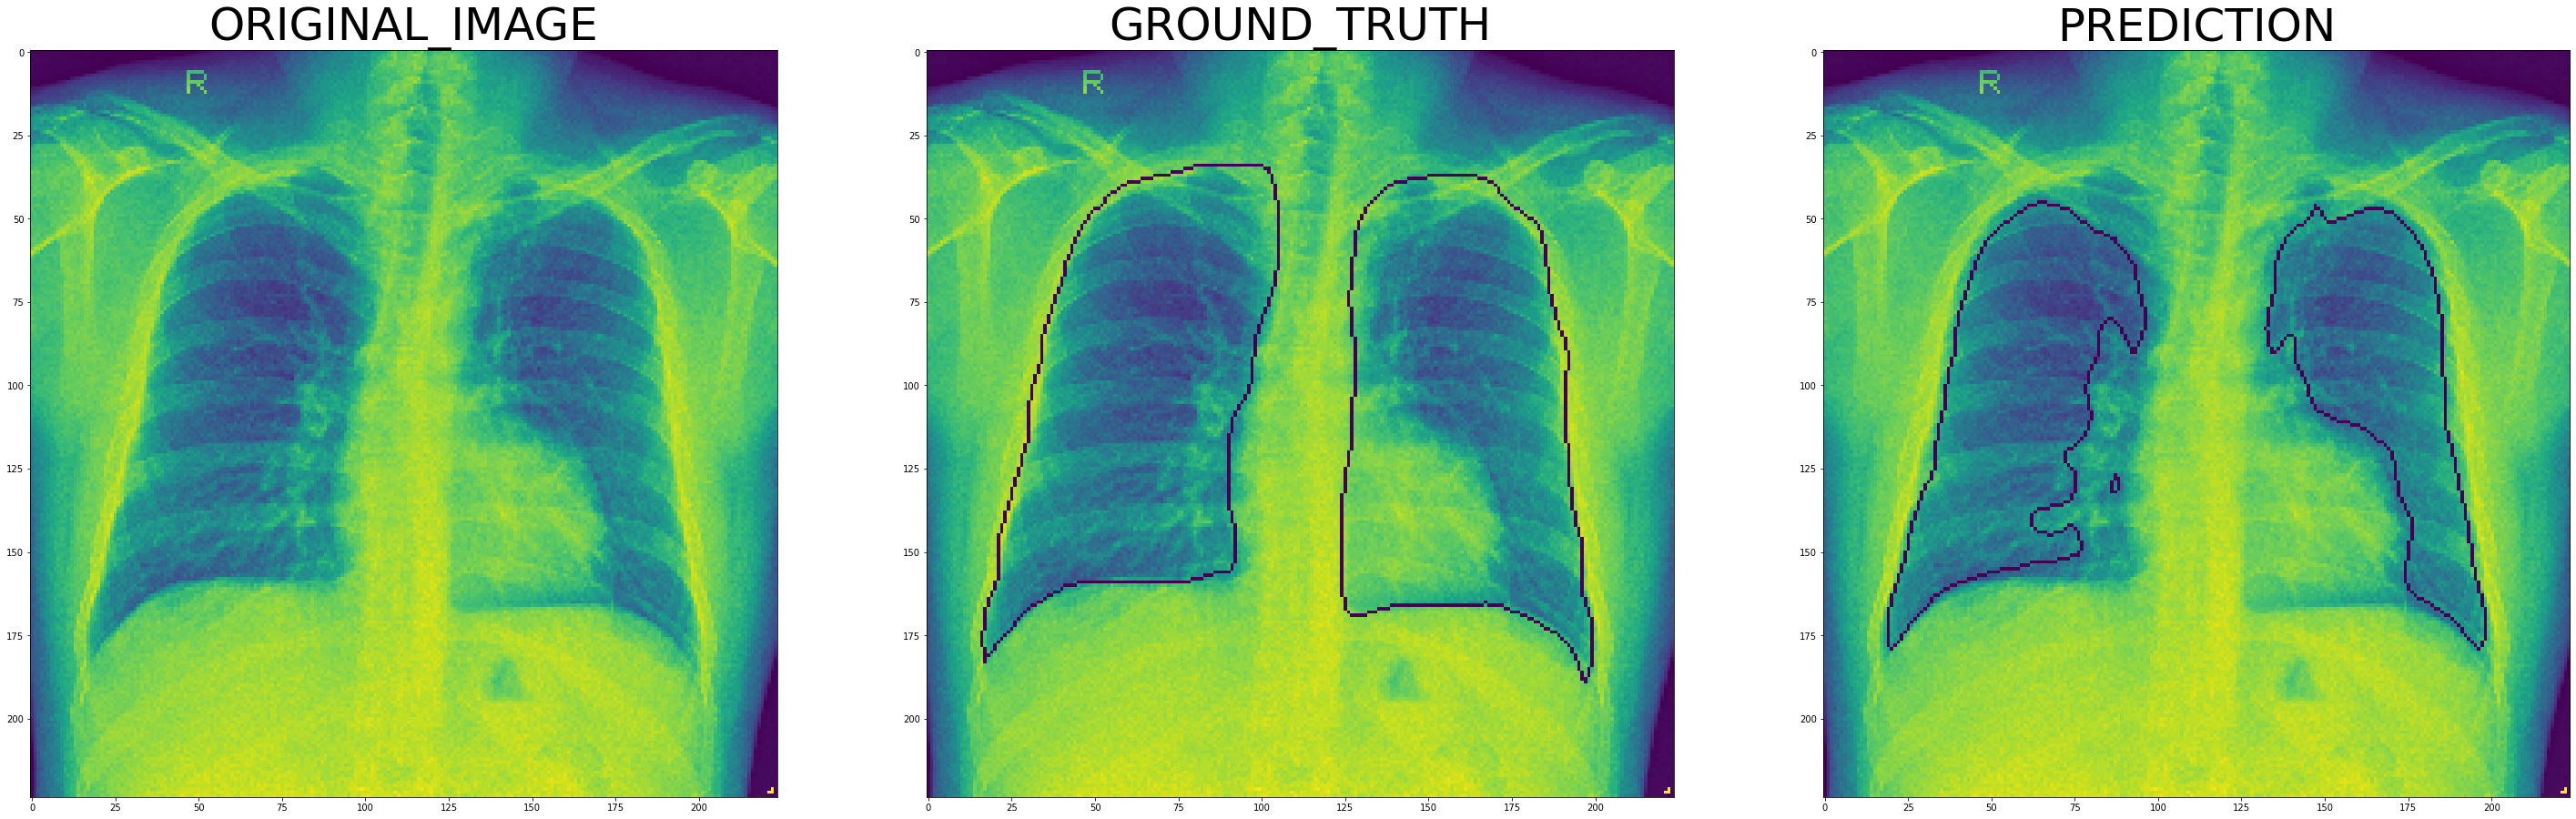

In [ ]:
#image_path='/content/CHNCXR_0329_1.png'
import matplotlib.pyplot as plt
images=[]
paths=['/content/gdrive/MyDrive/CHNCXR_0329_1.png','/content/gdrive/MyDrive/CHNCXR_0330_1.png','/content/gdrive/MyDrive/CHNCXR_0335_1.png','/content/gdrive/MyDrive/CHNCXR_0332_1.png','/content/gdrive/MyDrive/CHNCXR_0340_1.png']
for i in range(len(paths)):
  image_path=paths[i]
  test_image = image.load_img(image_path, target_size = (224, 224)) 
  test_image = np.expand_dims(test_image, axis = 0)
  value_predicted = new_model.predict(test_image)
  if((value_predicted)>0.5):
    #print("TUBERCULOSIS : ",value_predicted)
    x,y,z=segment(image_path)
    print("ee")
    plot(x,y,z,value_predicted)
  else:
    print("NORMAL : ",value_predicted)


TUBERCULOSIS :  [[0.90005016]]


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


TUBERCULOSIS :  [[0.93776125]]
TUBERCULOSIS :  [[0.89214134]]
TUBERCULOSIS :  [[0.99740547]]
TUBERCULOSIS :  [[0.90363556]]
TUBERCULOSIS :  [[0.9952722]]


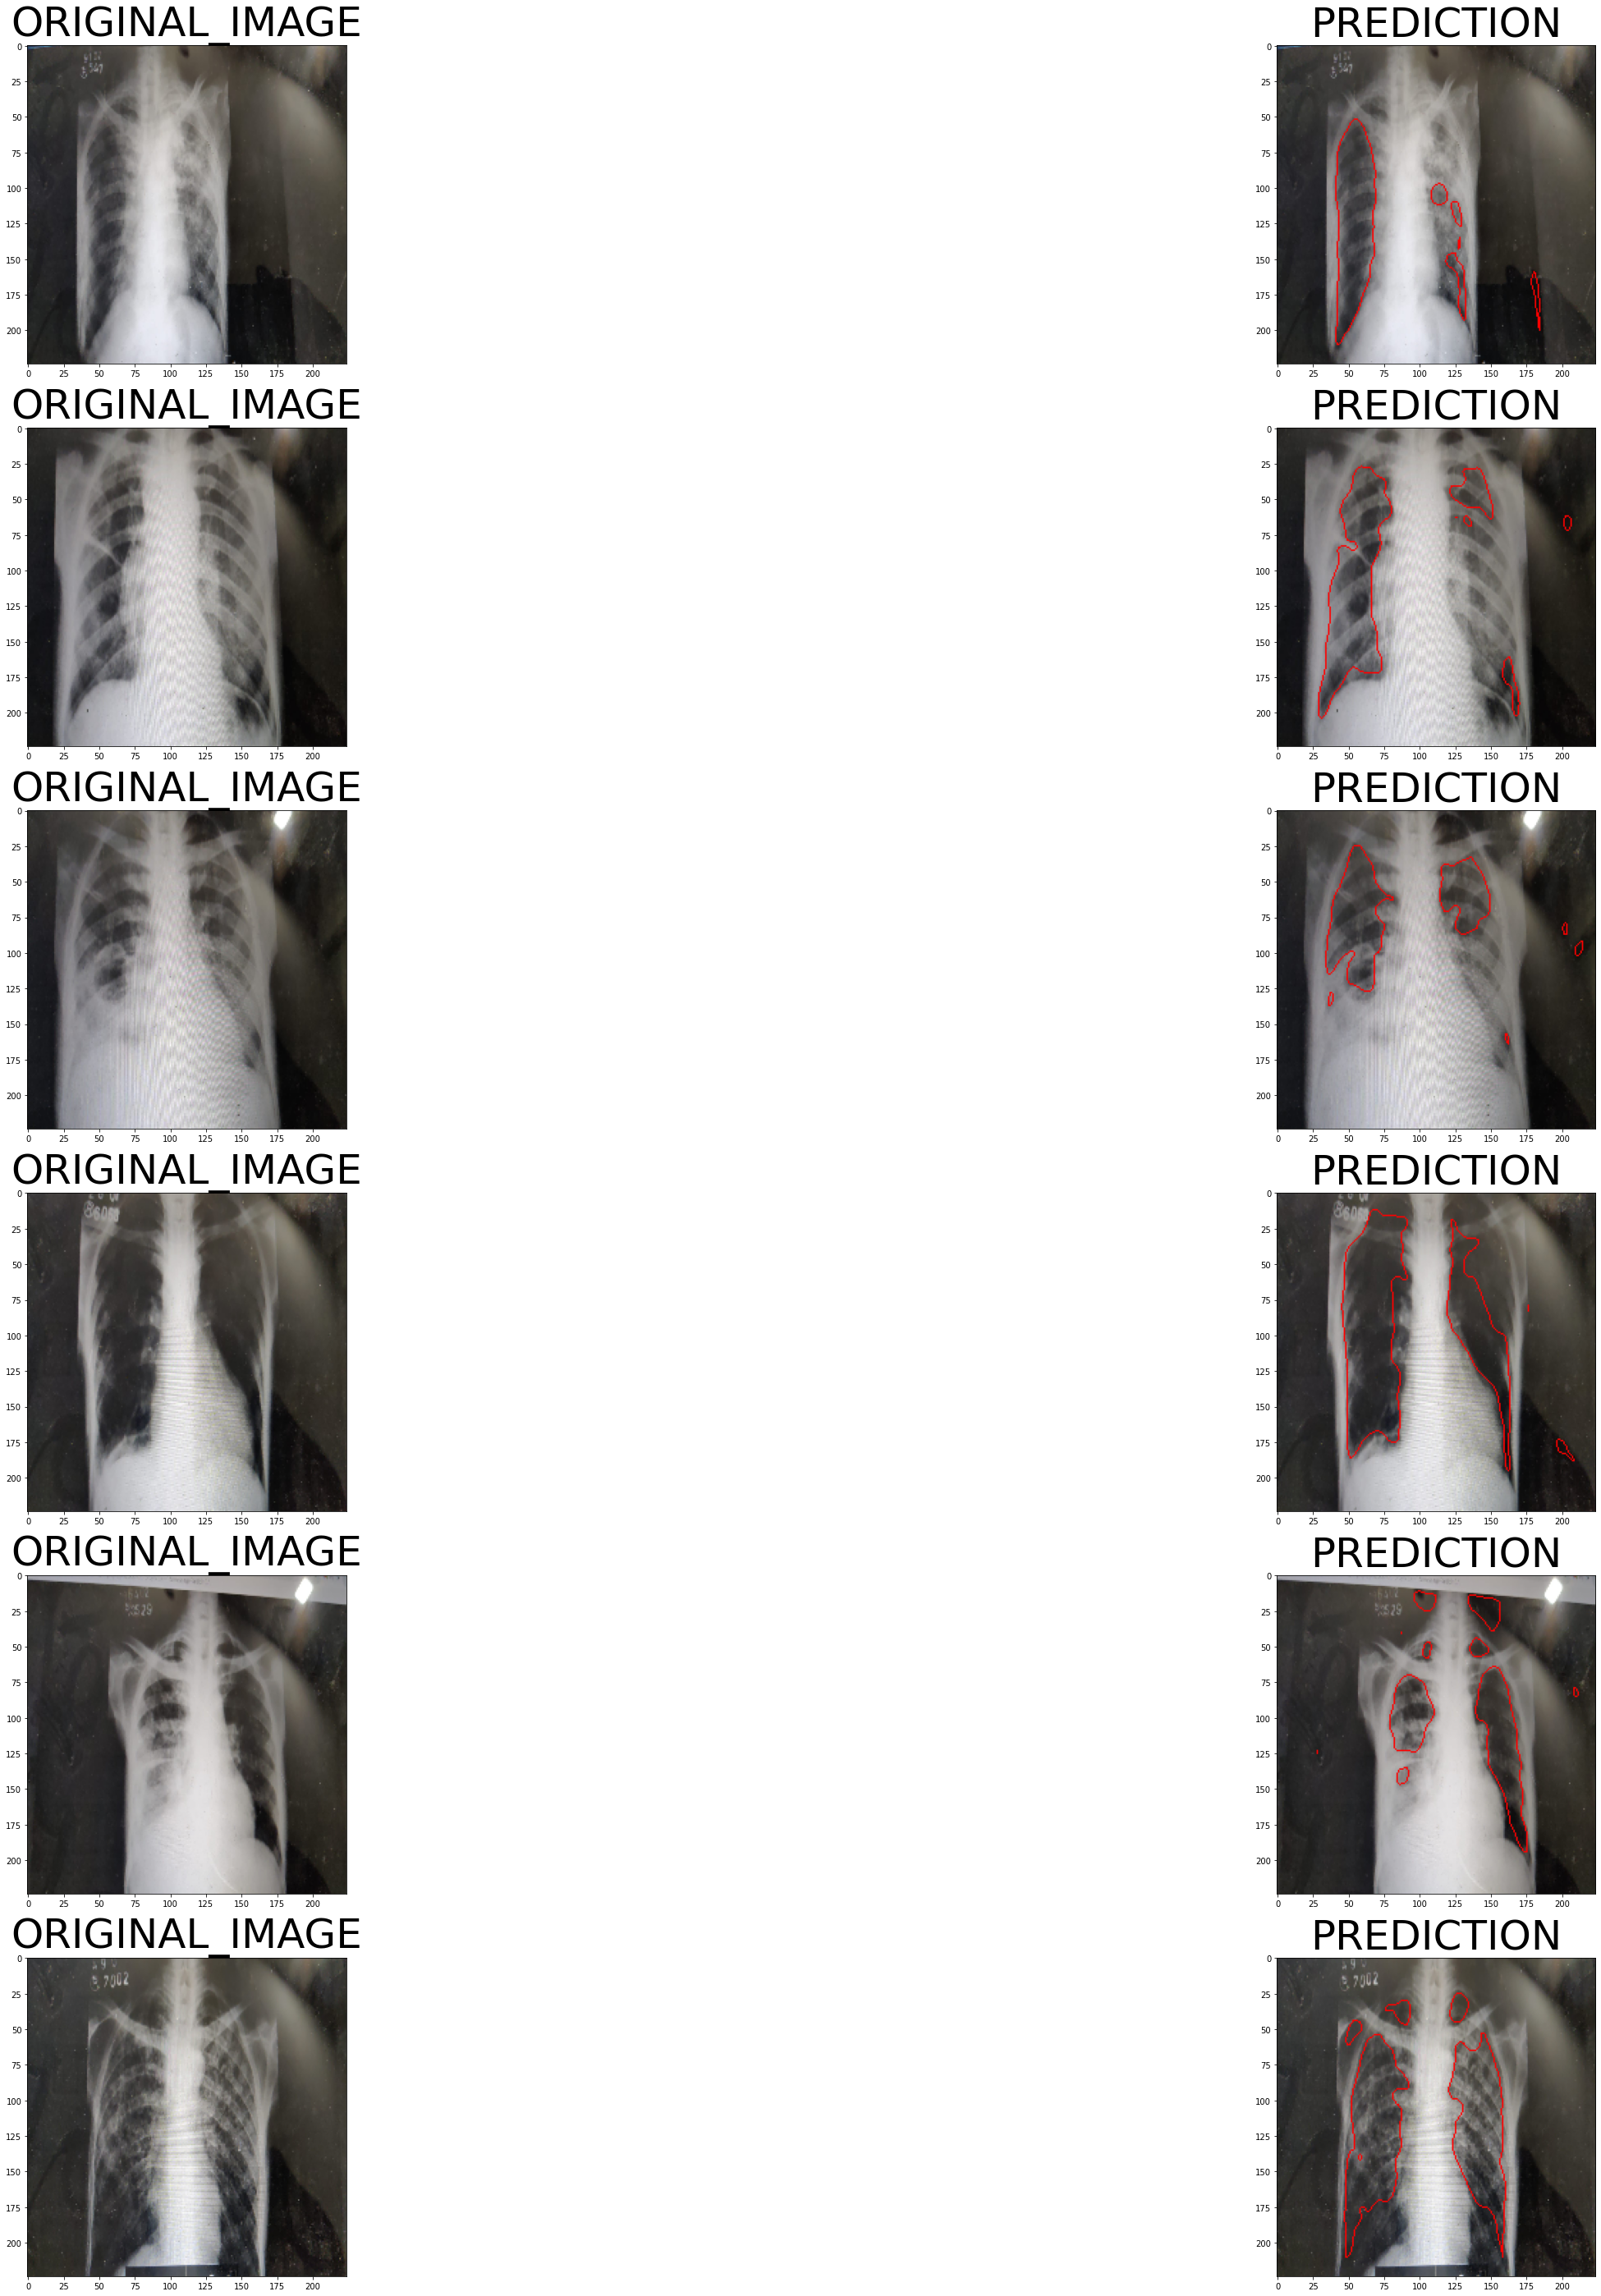

In [ ]:
#image_path='/content/gdrive/MyDrive/CHNCXR_0335_1.png'
images=[]
paths=['/content/gdrive/MyDrive/2.jpeg','/content/gdrive/MyDrive/3.jpeg','/content/gdrive/MyDrive/4.jpeg','/content/gdrive/MyDrive/5.jpeg','/content/gdrive/MyDrive/6.jpeg','/content/gdrive/MyDrive/7.jpeg']
for i in range(6):
  image_path=paths[i]
  test_image = image.load_img(image_path, target_size = (224, 224)) 
  test_image = np.expand_dims(test_image, axis = 0)
  value_predicted = new_model.predict(test_image)
  if((value_predicted)>0.5):
    print("TUBERCULOSIS : ",value_predicted)
    im,show1=segment(image_path,False)
    images.append((im,show1))
  else:
    print("NORMAL : ",value_predicted)
plt.figure(figsize=(50,50))
k=1
for i in range(1,7):
  f1=plt.subplot(6,2,k)
  plt.imshow(images[i-1][0])
  f1.set_title("ORIGINAL_IMAGE",fontsize=50)
  k+=1
  # f2=plt.subplot(7,2,k)
  # f2.set_title("GROUND_TRUTH",fontsize=50)
  # plt.imshow(images[i-1][1])
  # k+=1
  f3=plt.subplot(6,2,k)
  f3.set_title("PREDICTION",fontsize=50)
  plt.imshow(images[i-1][1])
  k+=1